In [1]:
!pip3 install gdown

In [2]:
!gdown --id 1a8NraomgEPv104-uG5AHbvUe49LuelaZ

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1a8NraomgEPv104-uG5AHbvUe49LuelaZ
From (redirected): https://drive.google.com/uc?id=1a8NraomgEPv104-uG5AHbvUe49LuelaZ&confirm=t&uuid=42af0c1f-22cb-429f-b65a-bb4ffb7a6bf7
To: /kaggle/working/S13.zip
100%|█████████████████████████████████████████| 125M/125M [00:00<00:00, 199MB/s]


In [3]:
!nvidia-smi

Fri Aug 25 20:58:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [4]:
!pip install kaggle

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = 'sushmithakatti'
os.environ['KAGGLE_KEY'] = '6d7e8c0e43edc088b2ac7a6ff8c06d1b'

In [6]:
!kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video

100%|██████████████████████████████████████▉| 4.30G/4.31G [00:29<00:00, 180MB/s]
100%|███████████████████████████████████████| 4.31G/4.31G [00:29<00:00, 158MB/s]


In [7]:
import zipfile

with zipfile.ZipFile('/kaggle/working/pascal-voc-dataset-used-in-yolov3-video.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [8]:
with zipfile.ZipFile('/kaggle/working/S13.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [9]:
cd S13

/kaggle/working/S13


In [10]:
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
config.NUM_WORKERS = 2

In [12]:
config.IMG_DIR = '/kaggle/working/PASCAL_VOC/images/'
config.LABEL_DIR = '/kaggle/working/PASCAL_VOC/labels/'
config.DATASET = '/kaggle/working/PASCAL_VOC/'
config.CONF_THRESHOLD = 0.5

In [13]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
loss_fn = YoloLoss()

In [14]:
!pip install torch_lr_finder

In [15]:
!pip install pytorch_lightning

In [16]:
import config
import numpy as np
import os
import pandas as pd
import torch
from utils import xywhn2xyxy, xyxy2xywhn
import random

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import (
    cells_to_bboxes,
    iou_width_height as iou,
    non_max_suppression as nms,
    plot_image
)

ImageFile.LOAD_TRUNCATED_IMAGES = True

class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=20,
        transform=None,
        mosaic_probability = 1.0,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.mosaic_border = [image_size // 2, image_size // 2]
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5
        self.mosaic_probability = mosaic_probability

    def __len__(self):
        return len(self.annotations)

    def load_mosaic(self, index):

        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4 = []
        s = self.image_size
        yc, xc = (int(random.uniform(x, 2 * s - x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(range(len(self)), k=3)  # 3 additional image indices
        random.shuffle(indices)
        for i, index in enumerate(indices):
            # Load image
            label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
            bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
            img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
            img = np.array(Image.open(img_path).convert("RGB"))


            h, w = img.shape[0], img.shape[1]
            labels = np.array(bboxes)

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            if labels.size:
                labels[:, :-1] = xywhn2xyxy(labels[:, :-1], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            labels4.append(labels)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)
        for x in (labels4[:, :-1],):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()
        # img4, labels4 = replicate(img4, labels4)  # replicate
        labels4[:, :-1] = xyxy2xywhn(labels4[:, :-1], 2 * s, 2 * s)
        labels4[:, :-1] = np.clip(labels4[:, :-1], 0, 1)
        labels4 = labels4[labels4[:, 2] > 0]
        labels4 = labels4[labels4[:, 3] > 0]
        return img4, labels4

    def __getitem__(self, index):

        if random.random() > self.mosaic_probability:
           label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
           bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
           img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
           image = np.array(Image.open(img_path).convert("RGB"))

        else:
          image, bboxes = self.load_mosaic(index)

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)



def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        "/kaggle/working/PASCAL_VOC/train.csv",
        "/kaggle/working/PASCAL_VOC/images/",
        "/kaggle/working/PASCAL_VOC/labels/",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
        mosaic_probability=0.8
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
# if __name__ == "__main__":
#     test()

In [17]:
from torch.utils.data import random_split
import pytorch_lightning as pl



class YOLODataModule(pl.LightningDataModule):
    def __init__(self,  batch_size, num_workers):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers


    def setup(self, stage):
        entire_dataset = YOLODataset(
            config.DATASET + "/train.csv",
            transform=config.train_transforms,
            S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
            img_dir=config.IMG_DIR,
            label_dir=config.LABEL_DIR,
            anchors=config.ANCHORS,
            mosaic_probability=0.7
        )
        train_size = int(0.7 * len(entire_dataset))
        val_size = len(entire_dataset) - train_size
        self.train_ds, self.val_ds = random_split(entire_dataset, [train_size, val_size])
        self.test_ds =YOLODataset(
             config.DATASET + "/test.csv",
            transform=config.test_transforms,
            S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
            img_dir=config.IMG_DIR,
            label_dir=config.LABEL_DIR,
            anchors=config.ANCHORS,
             mosaic_probability=0.0
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )




/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [18]:
dm = YOLODataModule(32,2)
dm.setup('val')
dm.setup('train')
dm.setup('test')

In [19]:
train_loader, test_loader, val_loader = dm.train_dataloader(), dm.test_dataloader(), dm.val_dataloader()

In [20]:
len(train_loader)

363

In [21]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR

import torch
import config
import torch.nn as nn
import torch.optim as optim
import utils

class Yolov3(pl.LightningModule):
    def __init__(self, model, scaled_anchors, train_loader = None, loss_fn = None,  in_channels=3, num_classes=20, threshold = 0.5,  learning_rate = 0.0001):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.loss_fn = loss_fn
        self.scaled_anchors = scaled_anchors
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.train_loader = train_loader
        self.model = model       
        
    def forward(self, x):
      return self.model(x)

    def training_step(self, batch, batch_idx):
     
        x, y = batch
        y0, y1, y2 = (
            y[0],
            y[1],
            y[2],
        )

        with torch.cuda.amp.autocast():
            out = self(x)
            loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0])
                + self.loss_fn(out[1], y1, self.scaled_anchors[1])
                + self.loss_fn(out[2], y2, self.scaled_anchors[2])
            )
        self.log('train_loss', loss,prog_bar=True)

        return {'loss': loss}
    

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y0, y1, y2 = (
            y[0],
            y[1],
            y[2],
        )

        with torch.cuda.amp.autocast():
            out = self(x)
            loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0])
                + self.loss_fn(out[1], y1, self.scaled_anchors[1])
                + self.loss_fn(out[2], y2, self.scaled_anchors[2])
            )
        self.log('val_loss', loss,prog_bar=True)
        return {'val_loss': loss}
     

    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx)
        
    def on_train_epoch_end(self,):
        if self.train_loader:
            check_class_accuracy(self, train_loader, threshold=config.CONF_THRESHOLD)



    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1E-3, weight_decay=1e-4)
        print("Learning Rate: ", self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr = 1E-3,   # Suggested LR
                                                epochs= self.trainer.max_epochs,
                                                steps_per_epoch= len(self.train_loader) if self.train_loader else 32,
                                                pct_start=5/self.trainer.max_epochs if self.trainer.max_epochs >= 5 else 1,
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                       )
        return [ optimizer],[ {'scheduler': scheduler,'interval': 'step', 'frequency': 1}]

In [22]:
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

from pytorch_lightning.callbacks import ModelSummary, ModelCheckpoint, LearningRateFinder
from pytorch_lightning import LightningModule, Trainer


module = Yolov3( model, scaled_anchors.to(config.DEVICE), train_loader = train_loader, loss_fn = loss_fn, in_channels=3, num_classes=20, threshold = 0.5)
module.hparams.lr = 1E-4
trainer = Trainer(
  precision="16-mixed",
    
  callbacks=[ModelCheckpoint(monitor='val_loss', filename='yolo_{epoch}') ],
  enable_progress_bar = True,
 
  devices = 1,
  accelerator="gpu",
  max_epochs=40,
 

)



In [23]:
trainer.fit(module, train_dataloaders = train_loader, val_dataloaders = val_loader )

Learning Rate:  0.0001


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:24<00:00,  1.06s/it]


Class accuracy is: 32.186565%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:23<00:00,  1.06s/it]


Class accuracy is: 33.198650%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:23<00:00,  1.06s/it]


Class accuracy is: 34.662048%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:20<00:00,  1.05s/it]

Class accuracy is: 33.876793%
No obj accuracy is: 98.565445%
Obj accuracy is: 11.960198%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:25<00:00,  1.06s/it]

Class accuracy is: 31.125248%
No obj accuracy is: 99.781929%
Obj accuracy is: 5.146194%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:21<00:00,  1.05s/it]

Class accuracy is: 31.203911%
No obj accuracy is: 99.885284%
Obj accuracy is: 2.946421%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:24<00:00,  1.06s/it]


Class accuracy is: 41.385929%
No obj accuracy is: 99.931969%
Obj accuracy is: 3.792417%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:25<00:00,  1.06s/it]


Class accuracy is: 44.493122%
No obj accuracy is: 99.582779%
Obj accuracy is: 15.333624%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:23<00:00,  1.06s/it]


Class accuracy is: 46.269012%
No obj accuracy is: 99.788712%
Obj accuracy is: 11.597768%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:25<00:00,  1.06s/it]


Class accuracy is: 51.188885%
No obj accuracy is: 99.729385%
Obj accuracy is: 15.000306%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:23<00:00,  1.06s/it]

Class accuracy is: 49.434517%
No obj accuracy is: 99.424377%
Obj accuracy is: 23.190891%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:25<00:00,  1.06s/it]

Class accuracy is: 47.627510%
No obj accuracy is: 99.668053%
Obj accuracy is: 18.144016%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:29<00:00,  1.07s/it]

Class accuracy is: 47.263737%
No obj accuracy is: 99.726097%
Obj accuracy is: 15.494506%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]

Class accuracy is: 41.846073%
No obj accuracy is: 99.802589%
Obj accuracy is: 11.923102%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]

Class accuracy is: 14.280723%
No obj accuracy is: 99.921310%
Obj accuracy is: 4.608680%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:25<00:00,  1.06s/it]


Class accuracy is: 53.276848%
No obj accuracy is: 99.720589%
Obj accuracy is: 17.524519%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:32<00:00,  1.08s/it]

Class accuracy is: 49.034168%
No obj accuracy is: 99.379333%
Obj accuracy is: 23.254930%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]

Class accuracy is: 49.248245%
No obj accuracy is: 99.653259%
Obj accuracy is: 15.513341%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:29<00:00,  1.07s/it]


Class accuracy is: 57.583923%
No obj accuracy is: 99.745354%
Obj accuracy is: 21.036091%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:29<00:00,  1.07s/it]

Class accuracy is: 55.297596%
No obj accuracy is: 99.769768%
Obj accuracy is: 18.726856%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:29<00:00,  1.07s/it]

Class accuracy is: 51.209824%
No obj accuracy is: 99.640366%
Obj accuracy is: 18.853006%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:36<00:00,  1.09s/it]


Class accuracy is: 59.931843%
No obj accuracy is: 99.616287%
Obj accuracy is: 26.878510%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:39<00:00,  1.10s/it]


Class accuracy is: 61.327171%
No obj accuracy is: 99.695274%
Obj accuracy is: 23.616713%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:26<00:00,  1.06s/it]


Class accuracy is: 61.093010%
No obj accuracy is: 99.710014%
Obj accuracy is: 23.405834%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:29<00:00,  1.07s/it]


Class accuracy is: 64.833450%
No obj accuracy is: 99.620499%
Obj accuracy is: 30.412806%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:27<00:00,  1.07s/it]


Class accuracy is: 64.365097%
No obj accuracy is: 99.462822%
Obj accuracy is: 33.142384%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]

Class accuracy is: 62.422245%
No obj accuracy is: 99.577240%
Obj accuracy is: 31.777504%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:27<00:00,  1.07s/it]


Class accuracy is: 66.511276%
No obj accuracy is: 99.699249%
Obj accuracy is: 26.067226%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]


Class accuracy is: 68.619987%
No obj accuracy is: 99.574013%
Obj accuracy is: 33.688728%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]


Class accuracy is: 70.000526%
No obj accuracy is: 99.574158%
Obj accuracy is: 34.638699%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:30<00:00,  1.07s/it]


Class accuracy is: 70.689873%
No obj accuracy is: 99.501328%
Obj accuracy is: 37.395744%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:26<00:00,  1.06s/it]


Class accuracy is: 71.236610%
No obj accuracy is: 99.569611%
Obj accuracy is: 34.765026%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:29<00:00,  1.07s/it]


Class accuracy is: 74.105225%
No obj accuracy is: 99.549194%
Obj accuracy is: 38.683887%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:27<00:00,  1.07s/it]


Class accuracy is: 73.926941%
No obj accuracy is: 99.517593%
Obj accuracy is: 39.646881%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:27<00:00,  1.07s/it]


Class accuracy is: 74.715927%
No obj accuracy is: 99.508675%
Obj accuracy is: 40.897705%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:30<00:00,  1.08s/it]


Class accuracy is: 76.120590%
No obj accuracy is: 99.510567%
Obj accuracy is: 42.086754%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:30<00:00,  1.08s/it]


Class accuracy is: 77.625786%
No obj accuracy is: 99.548378%
Obj accuracy is: 40.708790%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:28<00:00,  1.07s/it]


Class accuracy is: 78.401604%
No obj accuracy is: 99.465935%
Obj accuracy is: 44.711792%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:33<00:00,  1.08s/it]


Class accuracy is: 79.344437%
No obj accuracy is: 99.547966%
Obj accuracy is: 42.479122%


Validation: 0it [00:00, ?it/s]


100%|██████████| 363/363 [06:30<00:00,  1.07s/it]


Class accuracy is: 79.791435%
No obj accuracy is: 99.524590%
Obj accuracy is: 43.485447%


In [24]:
trainer.save_checkpoint('yolov3_20_epochs.ckpt')

In [25]:
utils.check_class_accuracy(module.to(config.DEVICE), test_loader, threshold=config.CONF_THRESHOLD)

100%|██████████| 155/155 [01:19<00:00,  1.94it/s]

Class accuracy is: 85.926849%
No obj accuracy is: 99.777687%
Obj accuracy is: 36.774731%


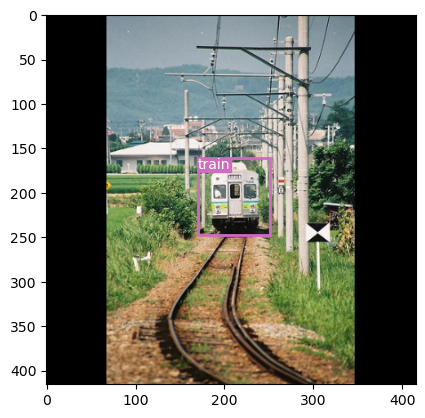

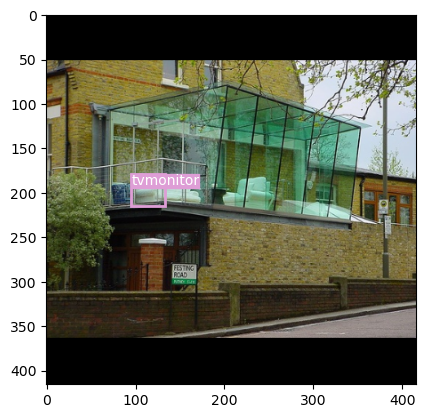

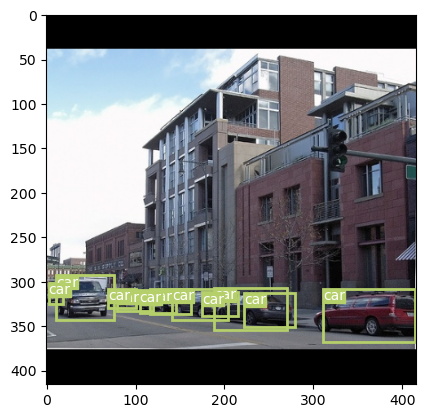

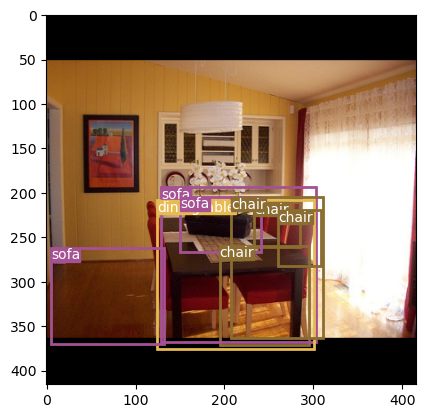

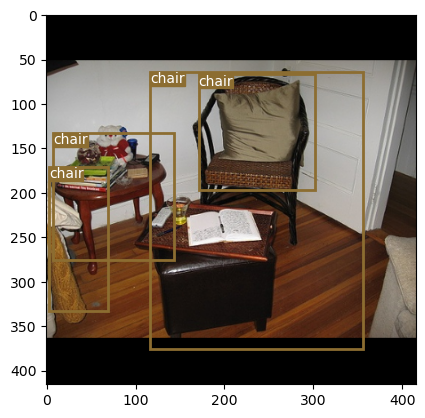

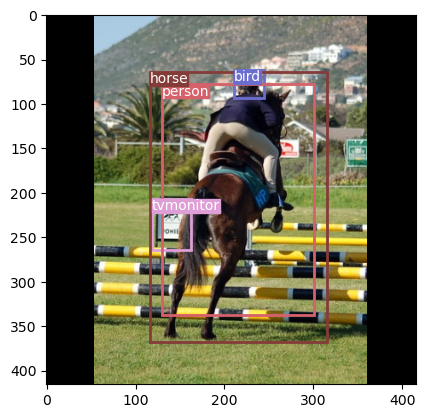

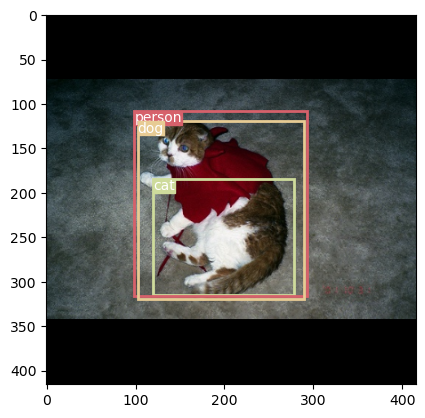

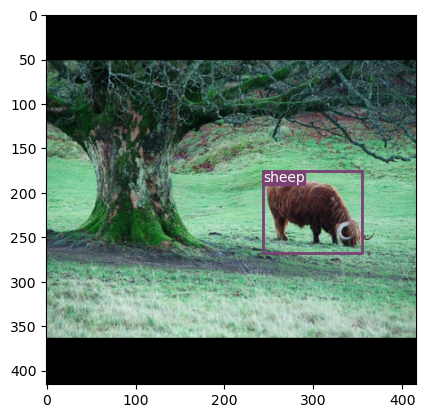

In [26]:
plot_couple_examples(module, test_loader, 0.5, 0.5, scaled_anchors)

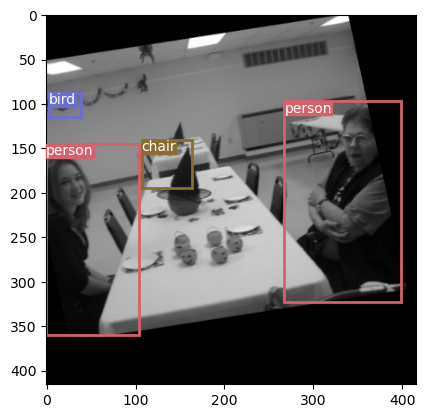

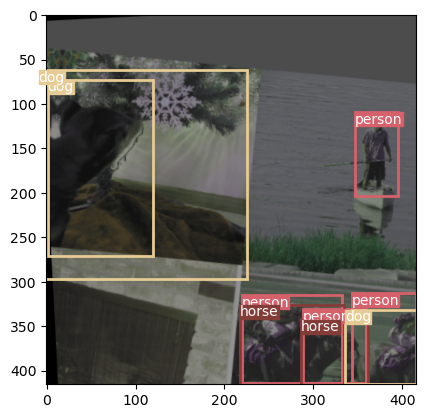

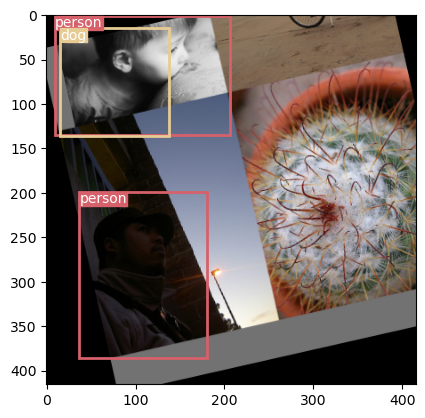

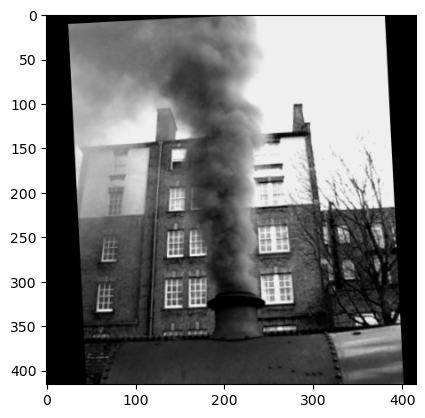

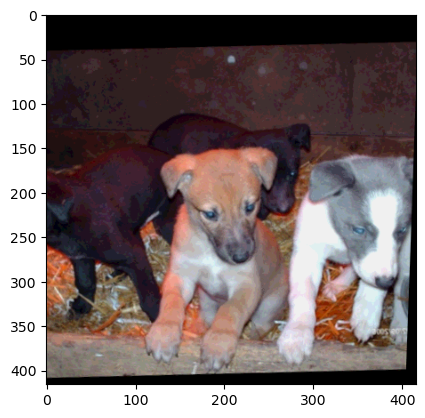

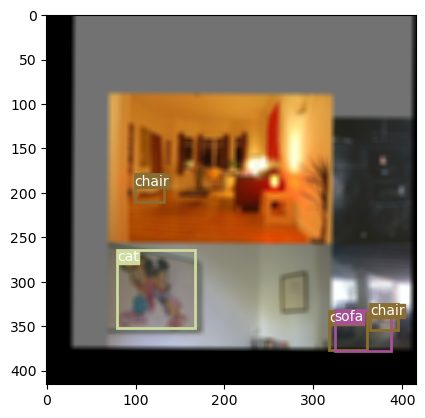

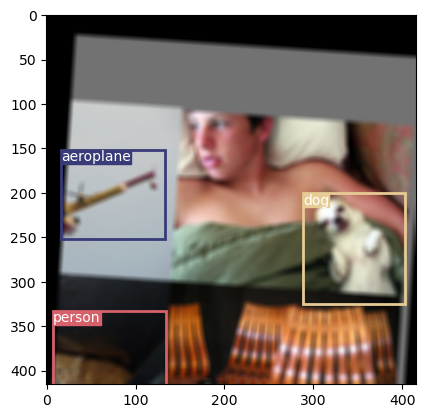

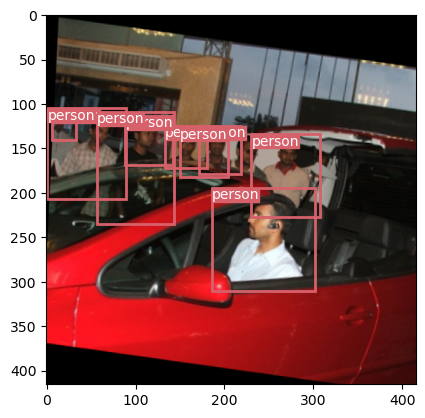

In [27]:
plot_couple_examples(model, val_loader, 0.6, 0.5, scaled_anchors)

In [28]:

pred_boxes, true_boxes = get_evaluation_bboxes(
test_loader,
module,
iou_threshold=config.NMS_IOU_THRESH,
anchors=config.ANCHORS,
threshold=config.CONF_THRESHOLD,
)


100%|██████████| 155/155 [05:00<00:00,  1.94s/it]


In [29]:
mapval = mean_average_precision(
        pred_boxes,
        true_boxes,
        iou_threshold=config.MAP_IOU_THRESH,
        box_format="midpoint",
        num_classes=config.NUM_CLASSES,
    )

In [30]:
mapval.item()

0.3674969971179962

In [31]:
plot_couple_examples(module2.to(config.DEVICE), test_loader, 0.5, 0.5, scaled_anchors)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plot_couple_examples(module2.to(config.DEVICE), test_loader, 0.5, 0.5, scaled_anchors)       │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'module2' is not defined

In [ ]:
module2 = Yolov3(model, scaled_anchors)

In [ ]:
module2 = module2.load_from_checkpoint('/kaggle/working/S13/yolov3_20_epochs.ckpt', model = model, scaled_anchors = scaled_anchors)

In [ ]:
utils.check_class_accuracy(module2.to(config.DEVICE), test_loader, threshold=config.CONF_THRESHOLD)

In [ ]:
module2.learning_rate

In [ ]:
module2.hparams.lr = 1E-5
trainer = Trainer(
  precision="16-mixed",
    
  callbacks=[ModelCheckpoint(monitor='val_loss', filename='yolo_{epoch}') ],
  enable_progress_bar = True,
 
  devices = 1,
  accelerator="gpu",
  max_epochs=1,
 

)


In [ ]:
trainer.test(module,test_loader)

In [ ]:
!pip install gradio

In [ ]:
!pip install grad_cam 

In [ ]:
import torch, torchvision
from torchvision import transforms
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import gradio as gr


In [ ]:
module2 = module2.to('cpu')

In [ ]:
module2.eval()
scaled_anchors = scaled_anchors.to('cpu')

In [ ]:
from typing import List
import torch
import numpy as np
import cv2
import random

from pytorch_grad_cam.base_cam import BaseCAM
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

class YoloCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(YoloCAM, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def forward(self,
                input_tensor: torch.Tensor,
                scaled_anchors: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            bboxes = [[] for _ in range(1)]
            for i in range(3):
                batch_size, A, S, _, _ = outputs[i].shape
                anchor = scaled_anchors[i]
                boxes_scale_i = cells_to_bboxes(
                    outputs[i], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes[idx] += box
            
            nms_boxes = non_max_suppression(
                bboxes[0], iou_threshold=0.5, threshold=0.5, box_format="midpoint",
            )
            # target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            target_categories = [box[0] for box in nms_boxes]
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output)
                       for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)
    
    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return get_2d_projection(activations)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2




def inference(input_img, threshold = 0.5, transparency = 0.5):
    
    transform = transforms.ToTensor()

    processed_image1 = np.array(input_img.copy())
    processed_image2 = processed_image1.copy()
    
    processed_image2 = cv2.resize(processed_image2, (416, 416))
    processed_image2 = np.float32(processed_image2) / 255

    transformed_img = transform(input_img)
    transformed_img = transformed_img.unsqueeze(0)
    
    # Model Predictions
    
    out = module2(transformed_img)
    bboxes = [[] for _ in range(transformed_img.shape[0])]
    for i in range(3):
        batch_size, A, S, _, _ = out[i].shape
        anchor = scaled_anchors[i]
        boxes_scale_i = utils.cells_to_bboxes(out[i], anchor, S=S, is_preds=True)
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] = box
        
    nms_boxes = utils.non_max_suppression(bboxes[0], 0.5, threshold, "midpoint" )
    cmap = plt.get_cmap('tab20b')
    class_labels = config.COCO_LABELS if config.DATASET=='COCO' else config.PASCAL_CLASSES
    colors = [[random.randint(0, 255) for _ in range(3)] for name in class_labels]
    
    
    
    # Draw the Predictions
    height, width, _ = processed_image1.shape
    bbox_thick = int(0.6 * (height + width) / 416)
    
    
    for box in nms_boxes:
         assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
         class_pred = box[0]
         box = box[2:]
         upper_left_x = box[0] - box[2]/2
         upper_left_y = box[1] - box[3]/2
            
         x1  = int(upper_left_x * width)
         y1 = int(upper_left_y * height)
        
         x2 = x1 + int(box[2] * width)
         y2 = y1 + int(box[3] * height)
            
         start_point = (x1, y1)
         end_point = (x2, y2)
            
         cv2.rectangle(processed_image1, start_point, end_point, colors[int(class_pred)], bbox_thick)
         text = f"{class_labels[int(class_pred)]}"
         cv2.putText(
            processed_image1,
            text,
            (x1, y1 - 2),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
             0.7,
            colors[int(class_pred)],
            bbox_thick // 2,
            lineType=cv2.LINE_AA,
            
        )
        

    # Grad Cam
    cam = YoloCAM(module2.to('cpu'), [module2.to('cpu').model.layers[-2]]
               , use_cuda=False)
    grayscale_cam = cam(transformed_img, scaled_anchors)[0,:,:]
    cam_image = show_cam_on_image(processed_image2, grayscale_cam, use_rgb=True, image_weight = transparency)
    return processed_image1, cam_image

title = "PASCAL Dataset trained on YOLOV3 Model with GradCAM"
description = "A simple Gradio interface to infer on YOLO V3 model, and get GradCAM results"

demo = gr.Interface(
    inference, 
    inputs = [gr.Image(shape=(416, 416), label="Input Image"), gr.Slider(0, 1, value = 0.5, label="threshold"), gr.Slider(0, 1, value = 0.5, step=1, label="GradCam Transparency")], 
    outputs = [ gr.Image(shape=(416, 416),label="Output"), gr.Image(shape=(416, 416),label="Output")],
    title = title,
    description = description,
#     examples = examples,
)
demo.launch(debug=True)



In [ ]:
x, y = next(iter(train_loader))
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

tensor = x[1].unsqueeze(0)
cam = YoloCAM(module2, [module2.model.layers[-1]]
               , use_cuda=True)

img = x[1].squeeze(0)
# img = inv_normalize(img)
rgb_img = np.transpose(img, (1, 2, 0))
rgb_img = rgb_img.numpy()
# 
grayscale_cam = cam(tensor, scaled_anchors)[0,:,:]


print(img.shape, grayscale_cam.shape)
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)